# Practical 3: Recurrent Neural Networks (RNNs)




## Introduction

Feedforward models (eg deep MLPs and ConvNets) map fixed-size input-data (vectors of a fixed dimensionality) to their output labels. They're very powerful and have been successfully used for many tasks. However, a lot of data is not in the form of fixed-size vectors, but exists in the form of **sequences**. Language is one good example, where sentences are sequences of words. In some way, almost any data types can be considered as a sequence (for instance an image consists of a sequence of pixels, speech a sequence of phonemes, and so forth). 

Recurrent neural networks (**RNNs**) were designed to be able to handle sequential data, and in this practical we will take a closer look at RNNs and then build a model that can generate English sentences in the style of Shakespeare!

## Learning Objectives
* Understand how RNNs model sequential data.
* Understand how the vanilla RNN is a generalization of feedforward models to incorporate sequential dependencies.
* Understand the issues involved when training RNNs.
* Know how to implement an RNN for time-series estimation (**regression**) and an RNN language model (character-level **classification**) in Tensorflow using Keras.

##Imports


In [3]:
#@title Imports (RUN ME!) { display-mode: "form" }

#!pip -q install pydot_ng
#!pip -q install graphviz
#!apt install graphviz > /dev/null

from __future__ import absolute_import, division, print_function

import numpy as np
import tensorflow as tf
import math
import random
import ssl
import sys
import urllib2
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print('Running TensorFlow version %s' % (tf.__version__))
try:
  tf.enable_eager_execution()
  print('Eager mode activated.')
except ValueError:
  print('Already running in Eager mode')

Running TensorFlow version 1.10.1
Eager mode activated.


##From Feedforward to Recurrent Models

### Intuition
RNNs generalize feedforward networks (FFNs) to be able to work with sequential data. FFNs take an input (e.g. an image) and immediately produce an output (e.g. a digit class), something like this:

In [0]:
def ffn_forward(x, W_xh, W_ho, b_hid, b_out):
 
    # Compute activations on the hidden layer.
    hidden_layer = act_fn(np.dot(W_xh, x) + b_hid)
    
    # Compute the (linear) output layer activations.     
    output = np.dot(W_ho, hidden_layer) + b_out
    
    return output

**NOTE**: You don't have to run this cell, it's just shown to illustrate the point.

RNNs, on the other hand, consider the data sequentially, and can remember what they have seen earlier in the sequence to help interpret or contextualize elements from later in the sequence when making predictions, something like this:


In [0]:
def rnn_forward(data_sequence, initial_state):

    state = initial_state  # Reused at every time-step
    all_states, all_ys = [state], []  # Used to save all states and predictions

    for x, y in data_sequence:
      
      # recurrent_fn() takes the current input and the previous state and produces a new state
      new_state, y_pred = recurrent_fn(x, state)
      
      all_states.append(new_state)
      all_ys.append(y_pred)
      
      # Update state for the next time-step
      state = new_state

    return all_states, all_ys

To understand the distinction between FFNs and RNNs, imagine we want to label words as the part-of-speech categories that they belong to: E.g. for the input sentence "I want a duck" and "He had to duck", we want our model to predict that duck is a `Noun` in the first sentence and a `Verb` in the second. To do this successfully, the model needs to be aware of the surrounding context. However, if we feed a FFN model only one word at a time, how could it know the difference? If we want to feed it all the words at once, how do we deal with the fact that sentences are of different lengths?

RNNs solve this issue by processing the sentence word-by-word, and maintaining an internal **state** summarizing what it has seen so far. This applies not only to words, but also to phonemes in speech, or even, as we will see, elements of a time-series.



### Unrolling the network

Imagine we are trying to classify a sequence $X = (x_1, x_2, \ldots, x_N)$ into labels $y$ (for now, let's keep it abstract). After running the `rnn_forward()` function of our RNN defined above on $X$, we would have a list of internal states and outputs of the model at each sequence position. This process is called **unrolling or unfolding in time**, because you can think of it as unrolling the *computations* defined by the RNN loop over the inputs at each position of the sequence.  RNNs are often used to model **time series data** (which we will do in this practical), and therefore these positions are referred to as **time-steps**, and hence we call this process "unrolling over time". See the visualization below from this great [blog post](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/) (it uses slightly different notation, but the idea should be clear):

![Unrolled Network](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/09/rnn.jpg)

> **We can therefore think of an RNN as a composition of identical feedforward neural networks (with replicated/tied weights), one for each moment or step in time. **

These feedforward functions that make up the RNN(i.e. our `recurrent_fn` above) are typically referred to as **cells**, and the only restriction on its API is that the cell function needs to be a differentiable function that can map an input and a state vector to an output and a new state vector. What we have shown above is called the **vanilla RNN**, but there are many more possibilities. One of the most popular variants is called the **Long Short-Term Memory (LSTM)** cell, which we'll use later to create our Shakespeare language model.

### Putting this together 

In the feedforward models we've seen before, the input $x$ is mapped to an intermediate hidden layer $h$ as follows:

\begin{equation}
  h = \sigma(\underbrace{W_{xh}x}_\text{current input (per-example)} + b)
\end{equation}

where $\sigma$ is some non-linear activation function like ReLU or tanh.  We can then make a prediction $\hat{y} = \sigma(W_{hy}h + b)$ based on $h$, or we can add another layer, etc.  **NOTE**: We use the weight subscript $W_{xz}$ to indicate a mapping from layer $x$ to layer $z$.

RNNs generalize this idea to a sequence of inputs $X = {x_1, x_2, ...}$ by maintaining a sequence of state vectors $h_t$, one for every time-step $t$, as follows:

\begin{equation}
  h_t = \sigma(\underbrace{W_{hh}h_{t-1}}_\text{previous state} + \underbrace{W_{xh}x_t}_\text{current input (per time-step)} + b)
\end{equation}

Feedforward models map one input to one output. On the other hand, RNNs can give **many-to-many** (many inputs, many labels), **many-to-one**, and **one-to-many** mappings. For example, we could use each $h_t$ to predict the part of speech for that time-step ($y_t= \sigma(W_{hy}h_t+b)$) or we could use the last state $h_T$ to predict the topic of the whole document. Which task the RNN performs is based on the training data (of course)! We can visualize these as follows (fromt this [excellent blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy):

![](http://karpathy.github.io/assets/rnn/diags.jpeg)

**QUESTIONS**
* How are FFNs and RNNs **similar**?
* How are they **different**?
* Why do we call RNNs "recurrent"?
* Can you think of a one-to-many task?

##Modeling General Time-Series

We will train an RNN to model a time-series as a first step. A **time-series** is a series of data-points ordered over discrete time-steps. Examples include the hourly temperature of Stellenbosch over a month or a year, the market price of some asset (like a company's stock) over time, and so forth. We will generate a **sinusoidal time-series** (with or without noise) as a toy example, and then train a tiny RNN model with only 5 parameters on this data.

###Create some artificial data

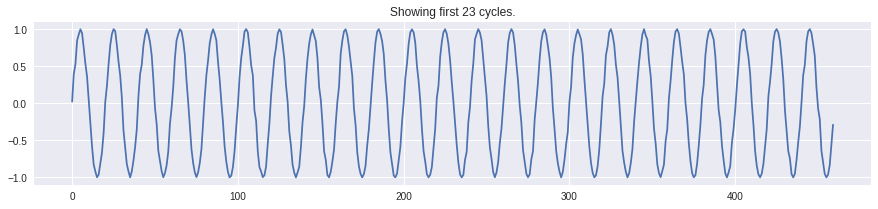

In [4]:
#@title Create sinusoidal data {run: "auto"}
steps_per_cycle = 20 #@param { type: "slider", min:1, max:100, step:1 }
number_of_cycles = 176 #@param { type: "slider", min:1, max:1000, step:1 }
noise_factor = 0.1 #@param { type: "slider", min:0, max:1, step:0.1 }
plot_num_cycles = 23 #@param { type: "slider", min:1, max:50, step:1 }

seq_len = steps_per_cycle * number_of_cycles
t = np.arange(seq_len)
sin_t_noisy = np.sin(2 * np.pi / steps_per_cycle * t + noise_factor * np.random.uniform(-1.0, +1.0, seq_len))
sin_t_clean = np.sin(2 * np.pi / steps_per_cycle * t)

upto = plot_num_cycles * steps_per_cycle
fig = plt.figure(figsize=(15,3))
plt.plot(t[:upto], sin_t_noisy[:upto])
plt.title("Showing first {} cycles.".format(plot_num_cycles))
plt.show()

#both = np.column_stack((t, sin_t_noisy))
#print("both.shape = {}".format(both.shape))

#print("both[:steps_per_cycle, :steps_per_cycle]")
#print(both[:steps_per_cycle,:steps_per_cycle])

**TASK**: Adjust the parameters above to generate data with different properties.

Now we pack the data into train and test batches. Note that while RNNs can in theory learn the dependencies across all inputs received so far (using an algorithm called **backpropagation through time**, or BPTT; see the Aside box below), in practice they are trained using an algorithm called **truncated BPTT** where we truncate the inputs to only the last $T$ symbols (this is the `truncated_seq_len` variable below).

**QUESTIONs**: 
* What issues can you think may arise by truncating the training data in this way? 
* Despite these issues, why do you think it might be necessary to do this?

In [0]:
#@title Pack truncated sequence data {run: "auto"}

def pack_truncated_data(data, num_prev = 100):  
    X, Y = [], []
    for i in range(len(data) - num_prev):
      X.append(data[i : i + num_prev])
      Y.append(data[i + num_prev])
    # NOTE: Keras expects input data in the shape (batch_size, truncated_seq_len, input_dim)
    # We have only one real-valued number per time-step, so we therefore expand 
    # the last dimension from (batch_size, truncated_seq_len) to 
    # (batch_size, truncated_seq_len, 1).
    X, Y = np.array(X)[:,:,np.newaxis], np.array(Y)[:,np.newaxis]
    return X, Y

# We only consider this many previous data points
truncated_seq_len = 2 #@param { type: "slider", min:1, max:10, step:1 }
test_split = 0.25  # Fraction of total data to keep out as test data

# We use only the sin(t) values, and discard the time values
data = sin_t_noisy
data_len = data.shape[0]
num_train = int(data_len * (1 - test_split))

train_data = data[:num_train]
test_data = data[num_train:]

X_train, y_train = pack_truncated_data(train_data, num_prev=truncated_seq_len)
X_test, y_test = pack_truncated_data(test_data, num_prev=truncated_seq_len)  

print("Generated training/test data with shapes\nX_train: {}, y_train: {}\nX_test: {}, y_test: {}. ".format(
    X_train.shape, y_train.shape, X_test.shape, y_test.shape))


Generated training/test data with shapes
X_train: (2638, 2, 1), y_train: (2638, 1)
X_test: (878, 2, 1), y_test: (878, 1). 


**NOTE**: We reshape the training data into (batch_size, truncated_seq_len, 1) and (batch_size, 1) arrays.

### Intermediate Aside: (Truncated) Backpropagation-through-Time and Vanishing and Exploding Gradients

RNNs model sequential data, and are designed to capture how ***outputs*** at the current time step are influenced by the ***inputs*** that came before them. This is referred to as **long-range dependencies**. At a high level, this allows the model to remember what it has seen so far in order to better contextualize what it is seeing at the moment (think about how knowing the context of the sentence or conversation can sometimes help one to better figure out the intended meaning of a misheard word or ambiguous statement). It is what makes these models so powerful, but it is also what makes them so hard to train!

The most well-known algorithm for training RNNs is called **back-propagation through time (BPTT**; there are other algorithms). BPTT conceptually amounts to unrolling the computations of the RNN over time, computing the errors, and backpropagating the gradients through the unrolled graph structure.  Ideally we want to unroll the graph up to the maximum sequence length, however in practice, since sequence lengths vary and memory is limited, we only end up unrolling sequences up to some length $T$. This is called **truncated BPTT**, and is the most used variant of BPTT.

At a high level, there are two main issues when using (truncated) BPTT to train RNNs:

* Having shared ("tied") recurrent weights ($W_{hh}$) mean that **the gradient on these weights at some time step $t$ depends on all time steps up to time-step $T$**, the length of the full (truncated) sequence. This also leads to the **vanishing/exploding gradients** problem, which we'll explain below.

* **Memory usage grows linearly with the total number of steps $T$ that we unroll for**, because we need to save/cache the activations at each time-step (look at the Python code above to convince yourself of this).  This matters computationally, since memory is a limited resource. It also matters statistically, because it puts a limit on the types of dependency that the model can successfully learn, by preventing it from correcting errors that stem from an input more than $T$ steps ago.

**NOTE**: Think about that last statement and make sure you understand those 2 points.

BPTT is very similar to the standard back-propagation algorithm. Key to understanding the BPTT algorithm is to realize that gradients on the non-recurrent weights (weights of a per time-step classifier that tries to predict the part-of-speech tag for each word for example) and recurrent weights (that transform $h_{t-1}$ into $h_t$) are computed differently:

* The gradients of **non-recurrent weights** ($W_{hy}$) depend only on the error at that time-step, $E_t$.
* The gradients of **recurrent weights** ($W_{hh}$) depend on all previous time-steps up to maximum length $T$.

The first point is fairly intuitive: predictions at time-step $t$ is related to the loss of that particular prediction. 

The second point will be explained in more detail in the lectures (see also [this great blog post](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/)), but briefly, this can be summarized in these equations:

1. The **current** state is a function of the **previous** state and the current input: $h_t = \sigma(W_{hh}h_{t-1} + W_{xh}x_t)$
2. The gradient of the loss $E_t$ at time $t$ on $W_{hh}$ is a function of the current hidden state and model predictions $\hat{y}_t$ at time t: 
$\frac{\partial E_t}{\partial W_{hh}} = \frac{\partial E_t}{\partial \hat{y}_t}\frac{\partial\hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial W_{hh}}$
3. Substituting (1) into (2) results in a **sum over all previous time-steps**:
$\frac{\partial E_t}{\partial W_{hh}} = \sum\limits_{k=0}^{t} \underbrace{\frac{\partial E_t}{\partial \hat{y}_t}\frac{\partial\hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial h_k}\frac{\partial h_k}{\partial W_{hh}}}_\text{product of gradient terms}$

The problem is that $\frac{\partial h_t}{\partial h_k} = \Pi_j \frac{\partial h_j}{\partial h_{j-1}}$ for j from $k + 1$ to $t$.  Because of this **repeated multiplicative interaction**, as the sequence length $t$ gets longer, the gradients themselves can get diminishingly small (**vanish**) or grow too large and result in numeric overflow (**explode**). This has been shown to be related to the norms of the recurrent weight matrices being less than or equal to 1. Intuitively, it works very similar to how multiplying a small number $v<1.0$ with itself repeatedly can quickly go to zero, or conversely, a large number $v>1.0$ could quickly go to infinity; only this is for matrices.


###Build a tiny RNN in Keras

Building an RNN in Keras is quite simple. We simply chain the layers together as follows:

In [0]:
def define_model(truncated_seq_len):  
    
    input_dimension = 1
    hidden_dimension = 1
    output_dimension = 1
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.SimpleRNN(
        # We need to specify the input_shape *without* leading batch_size (it is inferred)
        input_shape=(truncated_seq_len, input_dimension),
        units=hidden_dimension, 
        return_sequences=False,
        name='hidden_layer'))
    model.add(tf.keras.layers.Dense(
        output_dimension, 
        name='output_layer'))

    model.compile(loss="mean_squared_error", 
                  optimizer=tf.train.AdamOptimizer(learning_rate=1e-3))
    
    return model


**NOTE**: We're building an RNN for **regression**. We therefore use a linear layer (which outputs real-valued numbers) at the output with the "*mean_squared_error*" loss function.

In [0]:
model = define_model(truncated_seq_len = X_train.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (SimpleRNN)     (None, 1)                 3         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


**NOTE**: You need to re-run the above cell every time after training to reset the model weights!

###Train the tiny RNN
Now let's train the model. This may take a few minutes (it takes much longer if you increase `truncated_seq_len`). Set `verbose=1` **before** you run the cell to see the intermediate output as the model is training. Set it to 0 if you don't want any output.

In [0]:
''' SOLUTION TO ONE OF TASKS [DELETE]
patience = 5
train_history = model.fit(X_train, y_train, batch_size=600, epochs=1000, 
                          verbose=1, validation_split=0.05,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)])
'''

In [0]:
train_history = model.fit(X_train, y_train, batch_size=600, epochs=1000, 
                          verbose=1, validation_split=0.05)

Train on 2506 samples, validate on 132 samples
Epoch 1/1000
2506/2506 [==============================] - 0s 26us/step - loss: 0.4968 - val_loss: 0.4914
Epoch 2/1000
2506/2506 [==============================] - 0s 15us/step - loss: 0.4965 - val_loss: 0.4911
Epoch 3/1000
2506/2506 [==============================] - 0s 15us/step - loss: 0.4961 - val_loss: 0.4908
Epoch 4/1000
2506/2506 [==============================] - 0s 14us/step - loss: 0.4958 - val_loss: 0.4904
Epoch 5/1000
2506/2506 [==============================] - 0s 15us/step - loss: 0.4953 - val_loss: 0.4898
Epoch 6/1000
2506/2506 [==============================] - 0s 16us/step - loss: 0.4949 - val_loss: 0.4893
Epoch 7/1000
2506/2506 [==============================] - 0s 15us/step - loss: 0.4944 - val_loss: 0.4887
Epoch 8/1000
2506/2506 [==============================] - 0s 14us/step - loss: 0.4939 - val_loss: 0.4883
Epoch 9/1000
2506/2506 [==============================] - 0s 13us/step - loss: 0.4933 - val_loss: 0.4877
Epoch 10

Let's visualize the training and validation losses.

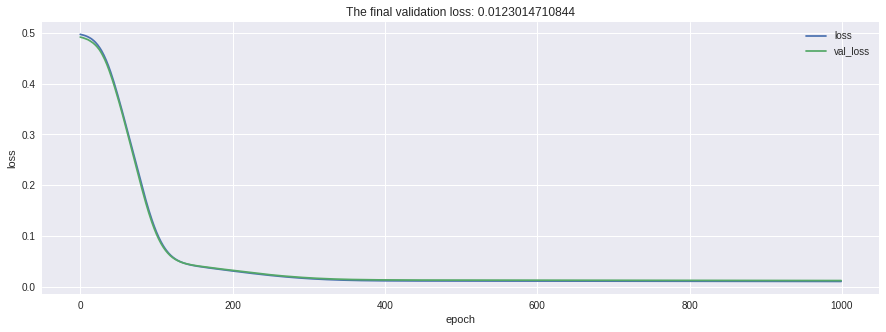

In [0]:
plt.figure(figsize=(15,5))

for label in ["loss","val_loss"]:
    plt.plot(train_history.history[label], label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(train_history.history["val_loss"][-1]))
plt.legend()
plt.show()

Finally, let's look at the parameters for the trained model.

In [0]:
for layer in model.layers:
  print("{}, {}".format(layer.name, layer.get_weights()))

hidden_layer, [array([[0.7633411]], dtype=float32), array([[-0.56165993]], dtype=float32), array([0.04831408], dtype=float32)]
output_layer, [array([[2.4384913]], dtype=float32), array([-0.06346191], dtype=float32)]


**QUESTION**: 
* Relate the above weights to the terms in the equation for the vanilla RNN we saw earlier, namely:
  * input-to-hidden $W_{xh}$,
  * hidden-to-hidden $W_{hh}$,
  * hidden-to-output weights $W_{hy}$
  * recurrent and out biases.

###Make predictions using the trained model

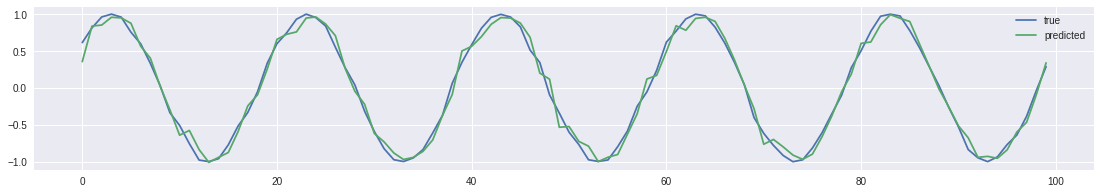

In [0]:
y_pred = model.predict(X_test[:100])
plt.figure(figsize=(19,3))

plt.plot(y_test[:100], label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

**YOUR TASKS**: 
* [**ALL**] Change the learning rate up to 5 orders of magnitude larger and smaller and retrain. What happens when it is too large? What happens when it is too small?
* [**ALL**] Change the `SimpleRNN` to `GRU`.
  * You can read more about LSTMs in [this blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Chris Olah. 
  * What is the effect on the number of parameters? Can you explain why? Now do the same for `LSTM`.
* [**INTERMEDIATE**] Note that the loss does not decrease much after around epoch 400. Add "Early Stopping with patience" to the `model.fit()` function to stop it from training beyond this point. **Hint**: Look at tf.keras.callbacks.
  * *Early stopping* is a technique where we stop training the model once it's performance on validation data stops improving, and is a very common approach to prevent overfitting. Early stopping *with patience* means as soon as the model starts doing worse on validation we wait for at least `patience` more evaluations before stopping training, and if it improves within that time, we reset the counter. The patience parameter is a way to ensure we don't stop by accident, as the validation loss can fluctuate randomly from epoch to epoch.


##Generating Shakespeare

Now let's build an RNN language model to generate Shakespearian English! A language model is trained to assign high probabilities to sequences of words or sentences that are well formed, and low probabilities to sequences which are not realistic. When the model is trained, one can use it to *generate* data that is similar to the training data.

Our data is now sequences of discrete symbols (characters). But neural networks operate in continuous spaces, and so we need to take the discrete language data, and **embed** it in a continuous space. To do this, we'll simply break up the data into sequences of characters, and represent each character using a learned vector. This is a standard trick for processing text using neural networks. 

### Download and Preprocess the Data

We first download the data and examine what it looks like:

In [0]:
context = ssl._create_unverified_context()
shakespeare_url = 'https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt'

data = urllib2.urlopen(shakespeare_url, context=context)
all_text = data.read().lower()

print("Downloaded Shakespeare data with {} characters.".format(len(all_text)))
print("FIRST 1000 CHARACTERS: ")
print(all_text[:1000])

Downloaded Shakespeare data with 4573338 characters.
FIRST 1000 CHARACTERS: 
first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you are all resolved rather to die than to famish?

all:
resolved. resolved.

first citizen:
first, you know caius marcius is chief enemy to the people.

all:
we know't, we know't.

first citizen:
let us kill him, and we'll have corn at our own price.
is't a verdict?

all:
no more talking on't; let it be done: away, away!

second citizen:
one word, good citizens.

first citizen:
we are accounted poor citizens, the patricians good.
what authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them let us revenge this with
our pikes, ere we become rakes: for

In [0]:
training_text = all_text[:1000000] # Keep only the first 1 million characters

We now preprocess the text data as follows:

1. Extract the vocabulary of all `vocab_size` unique characters appearing in the data.

2. Assign each character a unique integer id in `0 <= id < vocab_size`. This is so we can map the characters to unique embedding vectors. This is a common way to map discrete inputs to continuous vectors that neural networks can work with. See e.g. this [blog post](https://www.tensorflow.org/tutorials/representation/word2vec), or [this one](http://ruder.io/word-embeddings-1/) for more information.

3. Split the data into sequences ("windows") of `max_len` characters (the input to the model) followed by the next character as target. E.g. using `max_len=5` the sentence "I saw a cat" (11 characters) will get split into "I saw" and /space/, "/space/saw/space/" and "a", "saw a" and /space/, etc. To add some variation, we skip `step` characters between each sequence (i.e. we use a "sliding window of `max_len` with stride `step`").

In [0]:
max_len = 30  # We only consider this many previous data points (characters)
step = 3 # We start a new training sequence every `step` characters
sentences = [] # This holds our extracted sequences
next_chars = [] # This holds the targets (the follow-up characters)

chars = sorted(list(set(training_text)))  # List of unique characters in the corpus
vocab_size = len(chars)
print('Number of unique characters: ', vocab_size)
print(chars)

# Construct dictionaries mapping unique characters to their index in `chars` and reverse
char2index = dict((c, chars.index(c)) for c in chars)
index2char = dict((chars.index(c), c) for c in chars)

Number of unique characters:  39
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Now we encode the training data by mapping each character to its unique integer id.

In [0]:
for i in range(0, len(training_text) - max_len, step):
    sentences.append([char2index[s] for s in training_text[i: i + max_len]])
    next_chars.append([char2index[s] for s in training_text[i + max_len]])

print('Number of extracted sequences:', len(sentences))

Number of extracted sequences: 333324


This yields the following numpy arrays:

In [0]:
X, Y = np.array(sentences, dtype=np.int64), np.array(next_chars, dtype=np.int64)
X.shape, Y.shape

((333324, 30), (333324, 1))

Let's take a look at the first example.

In [0]:
print("X[0].shape = {}, Y[0].shape = {}".format(X[0].shape, Y[0].shape))
print("X[0]: ", X[0])
print("Y[0]: ", Y[0])

X[0].shape = (30,), Y[0].shape = (1,)
X[0]:  [18 21 30 31 32  1 15 21 32 21 38 17 26 10  0 14 17 18 27 30 17  1 35 17
  1 28 30 27 15 17]
Y[0]:  [17]


###Build an RNN language model

A **language model** estimates a probability distribution over sequences $\mathbb{x}_{1:N} = (x_1, x_2, ..., x_N)$ by breaking up the full joint probability into a sequence of conditional probabilities using the **[chain-rule of probability](https://en.wikipedia.org/wiki/Chain_rule_(probability))**:

\begin{align}
 p(\mathbb{x}_{1:N}) &= p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3 | x_2, x_1) \ldots \\
 &= \Pi_1^N p(x_i | \mathbb{x}_{1:i-1})
\end{align}

In other words, to model the probability of the phrase "*i saw a cat*" at the character level, the model learns to estimate the probabilities for p(i), p(/space/| i), p(c | i, /space/), and so forth, and multiplies them together. 

There are many different ways in which to estimate these individual probabilities. But one particularly effective way is to use an RNN! To do this, we'll therefore be modeling the  $p(x_i | \mathbb{x}_{1:i-1})$ terms using an RNN conditioned on $\mathbb{x}_{1:i-1}$.

* We model these probabilities at the character-level, so we'll use an `Embedding` layer as the first layer of our model to map the discrete character id's to real-valued embedding vectors. 
* Next, the RNN-core will map these sequences of character embeddings to a probability distribution over all characters $p(x_i | \mathbb{x}_{1:i-1}) \in \mathbb{R}^\textrm{vocab_size}$ at every step of the sequence. To do this, the RNN will map the embeddings to a sequence of *hidden states*. We will then use a `Dense` layer to map from the RNN hidden state to an output distribution over the total number of characters using a [`softmax`](https://en.wikipedia.org/wiki/Softmax_function) activation.

We can do this with a few lines of code:

In [0]:
embedding_dim = 32   # Map each character to a unique vector of this dimension
vocab_size = len(chars)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(
  vocab_size, embedding_dim, 
  input_length=max_len, 
  embeddings_initializer=tf.keras.initializers.TruncatedNormal))
model.add(tf.keras.layers.LSTM(
  128, 
  input_shape=(max_len, embedding_dim),  # NB: Ensure this matches the embedding_dim!
  dropout=0.1,  # input-to-hidden drop-probability
  recurrent_dropout=0.2))  # hidden-to-hidden drop-probability
model.add(tf.keras.layers.Dense(vocab_size, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 32)            1248      
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_2 (Dense)              (None, 39)                5031      
Total params: 88,711
Trainable params: 88,711
Non-trainable params: 0
_________________________________________________________________


###Select the optimizer and loss

Once we have a model that can map sequence of characters to a probability distribution over the next character in the sequence, we can train it using **maximum likelihood** on the training set to find the model parameters which maximizes the probability of the training data. Again, this is very simple to do by choosing an optimizer and selecting the `sparse_categorical_crossentropy` loss function:

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
loss='sparse_categorical_crossentropy'

model.compile(loss=loss, optimizer=optimizer)

###Helper functions

In [0]:
def sample_with_temp(preds, temperature=1.0):
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

In [0]:
def shift_and_append(test_arr, next_item):
  '''Returns a copy of test_arr with items shifted one position to the left and 
     next_item appended.
  '''
  tmp = np.empty_like(test_arr)
  tmp[:,:-1] = test_arr[:,1:]
  tmp[:,-1] = next_item
  return tmp

## TEST the above function:
test_arr = np.array([[1,2,3,4]])

print("test_arr = {}".format(test_arr))
test_arr = shift_and_append(test_arr, 5)
print("roll_arr(test_arr, 5) = {}".format(test_arr))

test_arr = [[1 2 3 4]]
roll_arr(test_arr, 5) = [[2 3 4 5]]


In [0]:
def sample_from_model(model, 
                      num_generate=400, 
                      prev_text=None,  # the text used to condition the model
                      temperatures=[0.2, 0.5, 1.0, 1.2]):
    
    if not prev_text:
      # Select a text seed at random
      start_index = random.randint(0, len(training_text) - max_len - 1)
      while ((start_index < (len(training_text) - max_len - 1)) and (
        training_text[start_index - 1] is not ' ')):
        start_index += 1  # Advance to beginning of new word
      prev_text = training_text[start_index: start_index + max_len]
    
    if len(prev_text) != max_len:
      print("`prev_text` must be of length `max_len`.")
      return

    print('GENERATING TEXT WITH SEED: \n"' + prev_text + '"')
    prev_text_arr = np.array(
      [[char2index[c] for c in prev_text]], dtype=np.int64) 
    
    for temp in temperatures:
        print('==TEMPERATURE:', temp)
        sys.stdout.write(prev_text)

        # Start with the same sampled text for all temperatures
        generated_text = prev_text 
        generated_text_arr = prev_text_arr

        # Now generate this many characters
        for i in range(num_generate):         
            
            # Get the output softmax given the conditioning text
            #prev_text = generated_text_enc[np.newaxis,:]
            preds = model.predict(generated_text_arr, verbose=0)[0]
            
            next_index = sample_with_temp(preds, temp)
            next_char = index2char[next_index]
            generated_text += next_char
            generated_text = generated_text[1:]

            # Left-shift and add into encoded array
            generated_text_arr = shift_and_append(generated_text_arr, next_index)

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

###Train the model

Let's train the model! The code below will train the model on a subset of the available data, and then generate from the model every `sample_every` number of batches.

To generate from the model, we use `model.predict()` on a sequence of `max_len` conditioning characters to produce an output distribution over `vocab_size` characters. We then sample one character from this distribution and shift everything up by one and append the new characters. By repeating this, we can generate text from the (partially-trained) model.

**NOTE**: 
* It takes a while to train a model that starts generating anything resembling the Shapespeare text! In general it should start getting the rough structure in place around the 100K training example mark (examples, not batches). But to generate any meaningful words will need several hundred thousand examples.
* We sample with *temperature*. This is a way to sharpen or flatten the probabilities produced by the model. By lowering the temperature, we emphasize the modes of the predicted distribution, and by increasing the temperature, we flatten the modes (tends towards uniform). Higher temperatures therefore encourage the model to be more 'creative', instead of always choosing the most likely next character.

In [0]:
batch_size = 128
total_num_batches = X.shape[0] // batch_size
sample_every = 256  # Train on this many batches, then generate something

print("Training on {} batches in total.".format(total_num_batches))

for cur_batch in range(0, total_num_batches, sample_every):
    print('TRAINING ON BATCH {} to {} (example {} to {})'.format(
      cur_batch, cur_batch + sample_every,
      cur_batch * batch_size, (cur_batch + sample_every) * batch_size)
    )
    
    X_batch = X[batch_size * cur_batch : batch_size * (cur_batch + sample_every), :]
    Y_batch = Y[batch_size * cur_batch : batch_size * (cur_batch + sample_every), :]
    
    '''
    # Show the first 5 examples to make sure we're not training on garbage
    print("X_batch.shape = {}".format(X_batch.shape))
    print("Y_batch.shape = {}".format(Y_batch.shape))
    print("FIRST 5 EXAMPLES:")
    for num in range(5):
      in_seq = [index2char[int(indx)] for indx in np.nditer(X_batch[num, :])]
      next_char = index2char[Y_batch[num, 0]]
      print(str(num) + '. ' + ''.join(in_seq) + '-->' + next_char)
    '''
       
    model.fit(X_batch, Y_batch,
              batch_size=batch_size,
              epochs=1,
              verbose=1)

    print("GENERATING SOME RANDOM TEXT FROM THE MODEL")
    sample_from_model(model)

Training on 2604 batches in total.
TRAINING ON BATCH 0 to 256 (example 0 to 32768)
Epoch 1/1
32768/32768 [==============================] - 124s 4ms/step - loss: 2.7223
GENERATING SOME RANDOM TEXT FROM THE MODEL
=====GENERATING TEXT WITH SEED: 
"else thou art suborn'd against"
==========TEMPERATURE: 0.2
else thou art suborn'd against sous the the the and the and wou the we hand the hand the and the our the han the ane the the ar the an the the and hand the hat he hand the the and and the the ser mous and the and the wous wou sert and the sou the wour yous wou whe wou the the the and the sou are he than the the mat ane the the wous an the the hand wou the hand the hat ane in the and the wind the the we the hare he and the and 
==========TEMPERATURE: 0.5
else thou art suborn'd against then wous tha collld me wall oucon isen sous, the ve i ande thene ase ak on? he the dens harendene and ous has the pour me mand an thean you ha co hat the and hene the se the or oure hare ias and the uin wo

KeyboardInterrupt: ignored

**NOTE**: Even after training has stopped you can still generate from the (partially trained) model as follows:

In [0]:
my_text = "       the meaning of life is:"  # Needs to be max_len characters
print(len(my_text))
sample_from_model(model, prev_text=my_text)

30


###IMPORTANT NOTES
* Even if you stop training the model weights are persistant. If you resume training it will start where you left off. 
* To reset the weights, you need to recompile the model.
* Sampling is **stochastic** (random), so you'll get new outputs every time you rerun the sampling code.

### YOUR TASKS: 
* [**ALL**] Read the generations from your model in a funny voice to your neighbour.
* [**ALL**] Increase `max_len` and regenerate the data and retrain the model.
 * What's the effect on training speed as you double `max_len`. Can you explain why?
 * Do you notice any effect on the quality of the model? Can you explain why?
* [**ALL**] Set the max_len to be roughly the length of half a word; one word; two words... What kind of samples do these models generate? Explain how they go wrong.
* [**ALL**] Change `embedding_dim` and the hidden size of the LSTM and observe the effect on training speed and quality.
* [**INTERMEDIATE**] Change the dropout rates & retrain the model. 
  * What types of dropout do we get for recurrent models? 
  * What's the effect on the text quality?
* [**ADVANCED**] Implement the "teacher forcing" training methodology, where the net must predict the entire output sequence shifted forward by one character, instead of just the next character. Compare the output of a model trained with teacher forcing versus the per-character model, given a similar training time. Is it fair to say that teacher forcing is a more efficient training methodology?


##Further reading

* https://distill.pub/2016/augmented-rnns/
* https://distill.pub/2017/ctc/
* https://algotravelling.com/en/machine-learning-fun-part-5/